In [32]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.io import read_image
import numpy as np
import pandas as pd
from collections import defaultdict
from shutil import copy

In [33]:
FOOD_PATH = "./dataset/food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"
TRAIN_PATH = FOOD_PATH+"/train"
VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'
# TRAIN_PATH = FOOD_PATH+"/images"
# VALID_PATH = FOOD_PATH+"/images"
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

In [16]:
TRAIN_PATH

'./dataset/food-101'

In [3]:
def random_images():
    root_dir = 'dataset/food-101/images/'
    rows = 17
    cols = 6
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
    fig.suptitle('Random Image from Each Food Class', fontsize=20)
    sorted_food_dirs = sorted(os.listdir(root_dir))
    for i in range(rows):
        for j in range(cols):
            try:
                food_dir = sorted_food_dirs[i*cols + j]
            except:
                break
            all_files = os.listdir(os.path.join(root_dir, food_dir))
            rand_img = np.random.choice(all_files)
            img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
            ax[i][j].imshow(img)
            ec = (0, .6, .1)
            fc = (0, .7, .2)
            ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                    ha="left", va="top", 
                    bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('images/random')

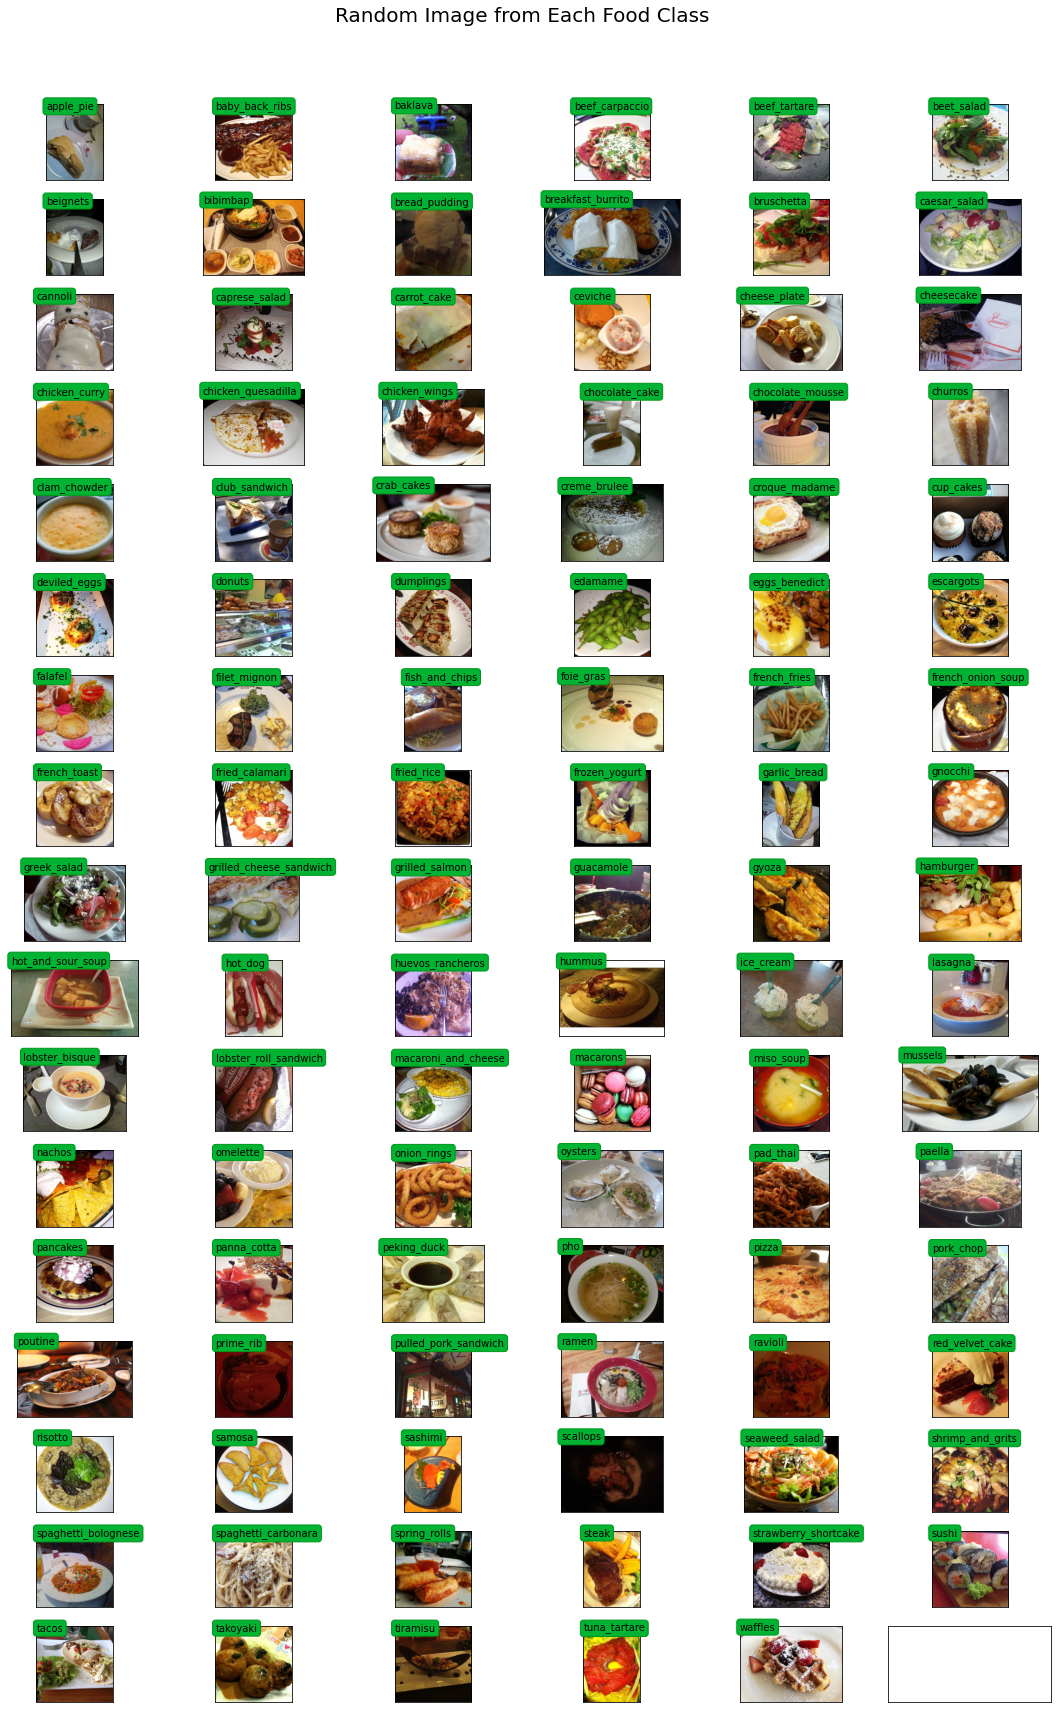

In [4]:
random_images()

In [34]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [35]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data(META_PATH+'/train.txt', IMG_PATH, TRAIN_PATH)

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [36]:
# Prepare validation data by copying images from food-101/images to food-101/valid using the file test.txt
print("Creating validation data...")
prepare_data(META_PATH+'/test.txt', IMG_PATH, VALID_PATH)

Creating validation data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copyi

In [37]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats[0]
        self.imgenet_std = imagenet_stats[1]
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return train_tfms, valid_tfms            
            
    def get_dataset(self,root_dir='dataset/food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)        
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes

    
    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs//2, shuffle=False, **kwargs))

In [46]:
food = FOOD101() 
train_ds, valid_ds, classes = food.get_dataset()
dls = food.get_dls(t, v, 20)
train_dl, valid_dl = dls[0], dls[1]

MODEL

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [38]:
def build_model():
    layers = []

    # in_channels, out_channels, kernel_size
    layers.append(nn.Conv2d(1, 3, 2, stride=2))
    layers.append(nn.MaxPool2d(2))

    layers.append(nn.Conv2d(3, 3, 2, stride=2))
    layers.append(nn.MaxPool2d(2))

    layers.append(nn.Conv2d(3, 3, 2, stride=2))
    layers.append(nn.MaxPool2d(2))


    layers.append(nn.Flatten())

    layers.append(nn.Linear(18, 400))
    layers.append(nn.ReLU())

    layers.append(nn.Linear(400, 101))
    layers.append(nn.ReLU())
    layers.append(nn.Softmax())
    
    model = nn.Sequential(*layers)
    
    return model

In [39]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [40]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
def train(model, train_dataloader, test_dataloader, learning_rate = 1e-6):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
    print("Done!")

In [43]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [48]:
model = build_model()
train(model, train_dl, valid_dl)

Epoch 1
-------------------------------


RuntimeError: Given groups=1, weight of size [3, 1, 2, 2], expected input[20, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
training_data = ImageDataset()

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
history = model.fit(train_batches,epochs=15, validation_data=valid_batches)

In [ ]:
model.evaluate(test_batches)